# BlockGen Graph Walkthrough

This notebook shows the new graph pipeline and starter model:
1. Load schematic files
2. Convert one structure into a torch_geometric graph
3. Verify the block/port-node schema
4. Run the `VoxelPortGNN` model
5. Do a tiny dummy training step

In [2]:
from pathlib import Path

import tqdm
import torch

try:
    import torch_geometric  # noqa: F401
except Exception as exc:
    raise RuntimeError(
        "torch_geometric is not installed in this environment. Install with: pip install .[gnn]"
    ) from exc

from blockgen.utils.graph_data import (
    EDGE_BLOCK_TO_PORT,
    EDGE_PORT_TO_PORT,
    NODE_BLOCK,
    NODE_PORT,
    dataset_from_directory,
)
from blockgen.models import VoxelPortGNN

print('torch:', torch.__version__)
print('cuda available:', torch.cuda.is_available())

torch: 2.10.0+cu128
cuda available: True


In [3]:
repo_root = Path.cwd()
if not (repo_root / 'data' / 'raw').exists():
    repo_root = repo_root.parent

raw_dir = repo_root / 'data' / 'raw'
assert raw_dir.exists(), f'Could not find raw data directory: {raw_dir}'

dataset = dataset_from_directory(raw_dir, crop_non_air=True, max_dim=48)
print('dataset size:', len(dataset))

dataset size: 10963


In [4]:
graph = dataset[0]

print('source path:', graph.source_path)
print('original/cropped shape (x,y,z):', tuple(graph.shape.tolist()))
print('num nodes:', graph.num_nodes)
print('num edges:', graph.edge_index.shape[1])
print('num block nodes:', graph.num_block_nodes)
print('expected nodes = blocks*7:', graph.num_block_nodes * 7)

source path: /home/griffing52/programming/gen/BlockGen/data/raw/1.schematic
original/cropped shape (x,y,z): (31, 11, 29)
num nodes: 12166
num edges: 27182
num block nodes: 1738
expected nodes = blocks*7: 12166


In [5]:
node_type = graph.node_type
edge_type = graph.edge_type
edge_index = graph.edge_index

num_block_nodes = int((node_type == NODE_BLOCK).sum().item())
num_port_nodes = int((node_type == NODE_PORT).sum().item())

print('block nodes:', num_block_nodes)
print('port nodes:', num_port_nodes)
print('expected port nodes = block_nodes*6:', num_block_nodes * 6)

block_to_port_edges = int((edge_type == EDGE_BLOCK_TO_PORT).sum().item())
port_to_port_edges = int((edge_type == EDGE_PORT_TO_PORT).sum().item())
print('block<->port edges:', block_to_port_edges)
print('port->port edges:', port_to_port_edges)

src_types = node_type[edge_index[0]]
dst_types = node_type[edge_index[1]]
block_block_edge_count = int(((src_types == NODE_BLOCK) & (dst_types == NODE_BLOCK)).sum().item())
print('block->block edges (should be 0):', block_block_edge_count)

assert num_port_nodes == num_block_nodes * 6
assert block_block_edge_count == 0
print('schema check passed ✅')

block nodes: 1738
port nodes: 10428
expected port nodes = block_nodes*6: 10428
block<->port edges: 20856
port->port edges: 6326
block->block edges (should be 0): 0
schema check passed ✅


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VoxelPortGNN(
    hidden_dim=128,
    num_layers=3,
    num_output_block_ids=4096,
).to(device)

graph = graph.to(device)
out = model(graph)

print('latent shape:', tuple(out['latent'].shape))
print('block_logits shape:', tuple(out['block_logits'].shape))
print('port_edge_logits shape:', tuple(out['port_edge_logits'].shape))

latent shape: (12166, 128)
block_logits shape: (1738, 4096)
port_edge_logits shape: (6326,)


In [7]:
# Tiny dummy training step to show the model is trainable end-to-end.
# Replace these targets with your real training targets later.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

block_logits = out['block_logits']
port_edge_logits = out['port_edge_logits']

target_block = torch.zeros(block_logits.size(0), dtype=torch.long, device=device)
target_edge = torch.ones(port_edge_logits.size(0), dtype=torch.float32, device=device)

loss_block = torch.nn.functional.cross_entropy(block_logits, target_block)
if target_edge.numel() > 0:
    loss_edge = torch.nn.functional.binary_cross_entropy_with_logits(port_edge_logits, target_edge)
else:
    loss_edge = torch.tensor(0.0, device=device)

loss = loss_block + 0.1 * loss_edge
optimizer.zero_grad()
loss.backward()
optimizer.step()

print('loss_block:', float(loss_block.item()))
print('loss_edge:', float(loss_edge.item()))
print('total_loss:', float(loss.item()))

loss_block: 8.276985168457031
loss_edge: 0.6711179614067078
total_loss: 8.344097137451172


## What to try next

- Iterate over multiple graphs with `torch_geometric.loader.DataLoader`
- Use `graph.block_id` (for block nodes) as supervised targets
- Add negative port-port samples for link prediction
- Save checkpoints and decode predicted IDs back to structure grids

## Crop vs No Crop

You do **not** have to crop.
- `crop_non_air=True` trims empty margins and usually speeds up graph creation/training.
- `crop_non_air=False` keeps absolute spatial context (including empty border regions).
For generation, a common first step is **masked reconstruction** (autoregressive-like): hide part of the structure, then predict the hidden blocks.

In [9]:
from blockgen.utils.graph_data import SchematicGraphDataset
cropped_ds = SchematicGraphDataset(dataset.schematic_paths[:1], crop_non_air=True, max_dim=32)
uncropped_ds = SchematicGraphDataset(dataset.schematic_paths[:1], crop_non_air=False, max_dim=32)
g_crop = cropped_ds[0]
g_full = uncropped_ds[0]
print('same file:', g_crop.source_path == g_full.source_path)
print('cropped shape:', tuple(g_crop.shape.tolist()), 'nodes:', g_crop.num_nodes)
print('uncropped shape:', tuple(g_full.shape.tolist()), 'nodes:', g_full.num_nodes)

same file: True
cropped shape: (31, 11, 29) nodes: 12166
uncropped shape: (31, 14, 29) nodes: 12166


## Tiny masked training run (autoregressive-like)
This is not full autoregressive decoding yet, but it is a practical first step:\n- Randomly mask some block nodes
- Predict masked block IDs from graph context
- Train with cross-entropy on only masked nodes

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from blockgen.utils.data import Structure
from blockgen.renderer.render import render_schem

# Small subset for a quick experiment
quick_paths = dataset.schematic_paths[:24]
train_ds = SchematicGraphDataset(
    quick_paths,
    include_air=False,
    crop_non_air=False,
    max_dim=20,
)
loader = DataLoader(train_ds, batch_size=4, shuffle=True)

quick_model = VoxelPortGNN(
    hidden_dim=96,
    num_layers=2,
    num_output_block_ids=512,
).to(device)
optimizer = torch.optim.Adam(quick_model.parameters(), lr=2e-3)


def make_masked_batch(batch, mask_prob=0.35):
    batch = batch.clone()
    block_nodes = torch.where(batch.node_type == NODE_BLOCK)[0]

    random_mask = torch.rand(block_nodes.numel(), device=batch.x.device) < mask_prob
    masked_nodes = block_nodes[random_mask]
    if masked_nodes.numel() == 0:
        masked_nodes = block_nodes[:1]

    targets = batch.block_id[masked_nodes].clone().long()

    # Hide ID/data features at masked block nodes.
    batch.block_id[masked_nodes] = 0
    batch.block_data[masked_nodes] = 0
    batch.x[masked_nodes, 1] = 0.0
    batch.x[masked_nodes, 2] = 0.0

    # Map global node idx -> row in block_logits
    row_map = torch.full((batch.num_nodes,), -1, dtype=torch.long, device=batch.x.device)
    row_map[block_nodes] = torch.arange(block_nodes.numel(), device=batch.x.device)
    masked_rows = row_map[masked_nodes]

    return batch, masked_rows, targets


quick_model.train()
for epoch in range(3):
    epoch_loss = 0.0
    num_batches = 0
    for batch in loader:
        batch = batch.to(device)
        masked_batch, masked_rows, targets = make_masked_batch(batch, mask_prob=0.35)

        out = quick_model(masked_batch)
        logits = out['block_logits'][masked_rows]

        # Keep targets in decoder range for this toy run
        targets = torch.remainder(torch.clamp(targets, min=0), logits.shape[1])

        loss = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += float(loss.item())
        num_batches += 1

    print(f'epoch {epoch+1}: loss={epoch_loss / max(1, num_batches):.4f}')

epoch 1: loss=6.0456
epoch 2: loss=3.8860
epoch 3: loss=2.4663


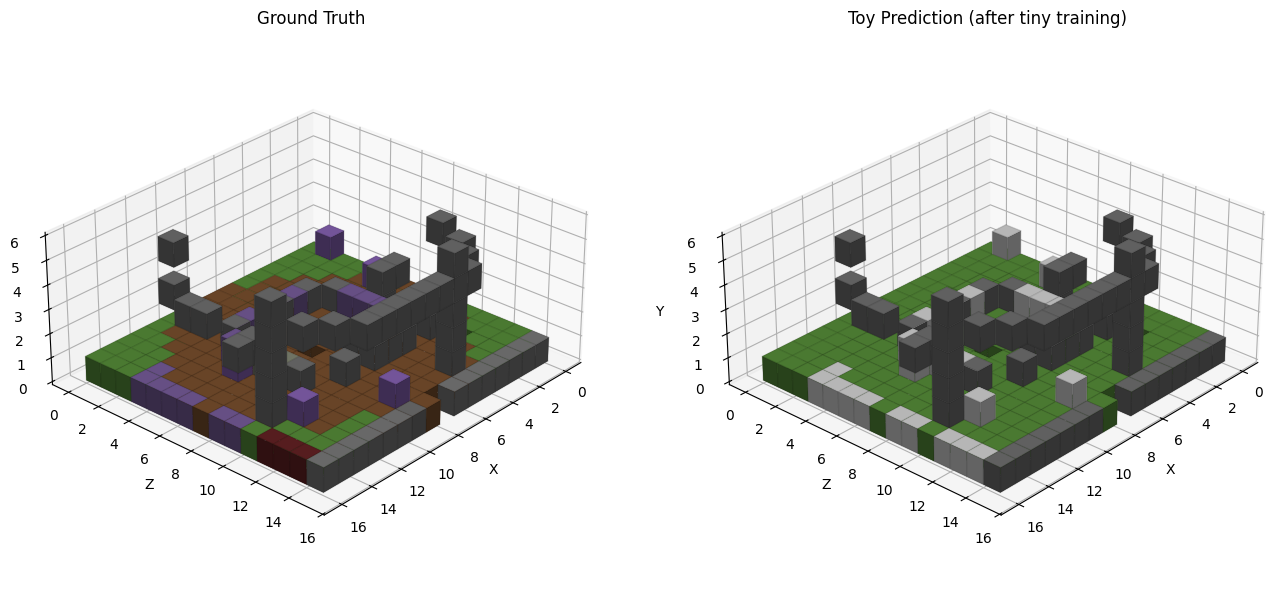

In [11]:
# Visualize one toy prediction vs ground truth
quick_model.eval()
with torch.no_grad():
    sample_graph = train_ds[0].to(device)
    masked_sample, _, _ = make_masked_batch(sample_graph, mask_prob=0.60)
    out = quick_model(masked_sample)

    pred_block_ids = out['block_logits'].argmax(dim=-1).detach().cpu().numpy()

sample_graph_cpu = sample_graph.cpu()
shape = tuple(int(v) for v in sample_graph_cpu.shape.tolist())

# Build ground-truth structure from block nodes
gt_ids = np.zeros(shape, dtype=np.int32)
gt_data = np.zeros(shape, dtype=np.int32)

block_nodes = torch.where(sample_graph_cpu.node_type == NODE_BLOCK)[0]
block_pos = sample_graph_cpu.pos[block_nodes].numpy()
true_ids = sample_graph_cpu.block_id[block_nodes].numpy()

for i, (x, y, z) in enumerate(block_pos):
    gt_ids[int(x), int(y), int(z)] = int(true_ids[i])

# Build predicted structure on same coordinates
pred_ids = np.zeros(shape, dtype=np.int32)
pred_data = np.zeros(shape, dtype=np.int32)
for i, (x, y, z) in enumerate(block_pos):
    pred_ids[int(x), int(y), int(z)] = int(pred_block_ids[i])

true_structure = Structure(block_ids=gt_ids, block_data=gt_data, source_path='ground_truth')
pred_structure = Structure(block_ids=pred_ids, block_data=pred_data, source_path='toy_prediction')

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
render_schem(true_structure, ax=ax1, show=False, crop_non_air=False, max_dim=20)
ax1.set_title('Ground Truth')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
render_schem(pred_structure, ax=ax2, show=False, crop_non_air=False, max_dim=20)
ax2.set_title('Toy Prediction (after tiny training)')

plt.tight_layout()
plt.show()